In [14]:
!kaggle datasets download -d sudarshanvaidya/random-images-for-face-emotion-recognition

Dataset URL: https://www.kaggle.com/datasets/sudarshanvaidya/random-images-for-face-emotion-recognition
License(s): unknown
 72%|████████████████████████████▏          | 33.0M/45.6M [00:00<00:00, 149MB/s]
100%|███████████████████████████████████████| 45.6M/45.6M [00:00<00:00, 156MB/s]


In [15]:
!unzip random-images-for-face-emotion-recognition.zip -d random-images-for-face-emotion-recognition

Archive:  random-images-for-face-emotion-recognition.zip
  inflating: random-images-for-face-emotion-recognition/anger/11647173796_033ff06112_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/1379351899_7cfa2b0dc4_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/14187801814_ea89208940_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/22600236939_54d0e01905_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/22721287949_65572bea8b_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/22913025801_2822113219_n_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/24063912157_38a4f8d093_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/2971847861_5c6fe61308_b_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/2Q__ (1)_face.png  
  inflating: random-images-for-face-emotion-recognition/anger/2Q__ (2)_face.png

## 1. Importation des Bibliothèques Nécessaires

In [7]:
!pip install --upgrade scikit-learn scikeras

In [10]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=88c823e04b55ffaedcc46d4a05a80a76bc31979a9fea5742980f527a17fc6b3f
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [11]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import imutils
import cv2
from IPython.display import display, Javascript
from base64 import b64decode
import torch
from torchvision import models, transforms as T
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split

In [16]:
# Définir les chemins des répertoires
data_dir = 'random-images-for-face-emotion-recognition'
train_dir = 'random-images-for-face-emotion-recognition/train'
test_dir = 'random-images-for-face-emotion-recognition/test'
img_size = (224, 224)
batch_size = 16

In [17]:
# Classes dans le répertoire original
original_classes = os.listdir(data_dir)

# Créer les répertoires d'entraînement et de test s'ils n'existent pas
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Vérifiez et synchronisez les répertoires d'entraînement et de test
for class_name in original_classes:
    if class_name in ['train', 'test']:
        continue  # Ignorer les répertoires d'entraînement et de test existants
    
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)
        
        train_images = os.listdir(train_class_dir)
        test_images = os.listdir(test_class_dir)
        
        # Si une classe manque dans un des ensembles, ajouter des images
        if len(train_images) == 0 or len(test_images) == 0:
            all_images = os.listdir(class_dir)
            train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
            
            for image in train_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(train_class_dir, image)
                copyfile(src, dst)
            
            for image in test_images:
                src = os.path.join(class_dir, image)
                dst = os.path.join(test_class_dir, image)
                copyfile(src, dst)

In [18]:
# Création des générateurs de données avec augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [19]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 4444 images belonging to 8 classes.


In [20]:
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1114 images belonging to 8 classes.


In [21]:
class_names = list(train_generator.class_indices.keys())
print("Classes dans l'ensemble d'entraînement:", len(train_generator.class_indices))
print("Classes dans l'ensemble de test:", len(test_generator.class_indices))

Classes dans l'ensemble d'entraînement: 8
Classes dans l'ensemble de test: 8


# RetinatNet

In [22]:
model = models.detection.retinanet_resnet50_fpn(pretrained=True)
model = model.eval()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 164MB/s]  


In [23]:
transform = T.Compose([
    T.ToTensor()
])

In [24]:
def detect_faces(image_path, model, transform, threshold=0.5):
    # Vérifier si le fichier existe
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Le fichier {image_path} n'existe pas.")

    # Charger et prétraiter l'image
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)

    # Effectuer la détection avec le modèle RetinaNet
    with torch.no_grad():
        outputs = model(image_tensor)

    boxes = outputs[0]['boxes']
    scores = outputs[0]['scores']

    # Filtrer les boîtes de délimitation avec un score supérieur au seuil
    boxes = boxes[scores > threshold]
    scores = scores[scores > threshold]

    # Réduire la taille des boîtes de délimitation
    scale_factor = 0.2  # Facteur de réduction de la taille de la boîte
    new_boxes = []
    for box in boxes:
        center_x = (box[0] + box[2]) / 2
        center_y = (box[1] + box[3]) / 2
        width = (box[2] - box[0]) * (1 - scale_factor)
        height = (box[3] - box[1]) * (1 - scale_factor)
        new_box = [center_x - width / 2, center_y - height / 2, center_x + width / 2, center_y + height / 2]
        new_boxes.append(new_box)

    new_boxes = torch.tensor(new_boxes)

    # Dessiner les boîtes de délimitation sur l'image originale
    image_tensor = image_tensor.squeeze(0).mul(255).byte()
    image_with_boxes = draw_bounding_boxes(image_tensor, new_boxes, colors="red", width=2)

    return image_with_boxes

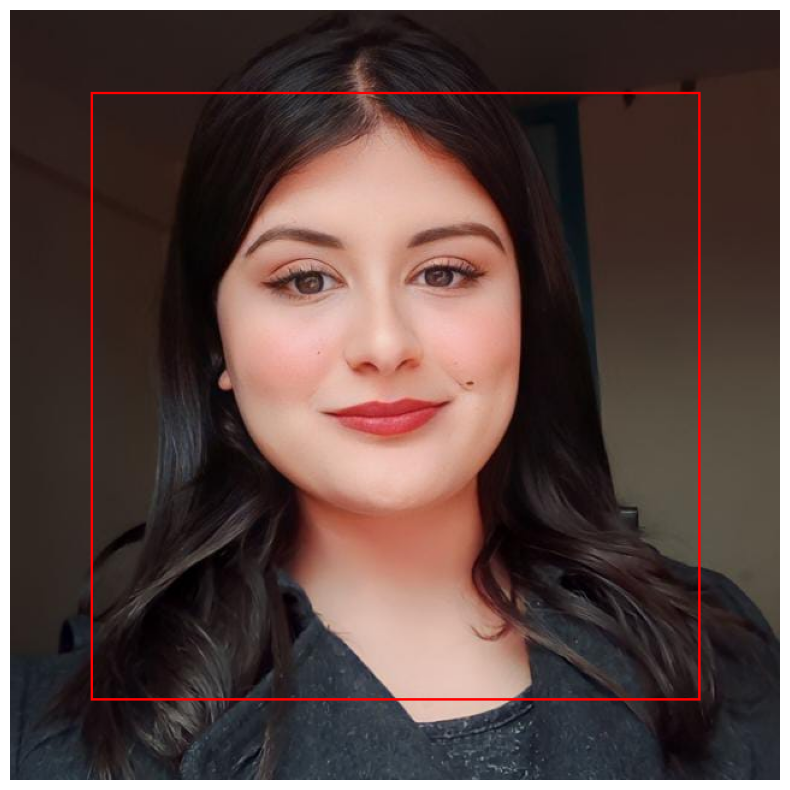

In [31]:
example_image_path = "/kaggle/input/phototest/photo.jpg"

if not os.path.exists(example_image_path):
    print(f"Le fichier {example_image_path} n'existe pas.")

else:
    image_with_boxes = detect_faces(example_image_path, model, transform, threshold=0.5)

    image_with_boxes = image_with_boxes.permute(1, 2, 0).numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()


## Detection faciale avec OpenCV et SSD

In [32]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# en temps reel :
# image_file = take_photo()

In [41]:
# exemple d'image
image_file = "/kaggle/input/phototest/photo.jpg"

400 400


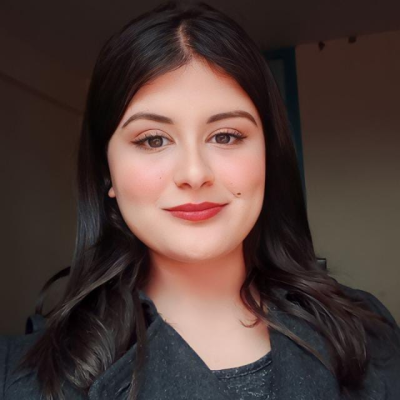

In [47]:
from IPython.display import display
from PIL import Image

image = cv2.imread(image_file)

# Redimensionner l'image pour avoir une largeur maximale de 400 pixels
image = imutils.resize(image, width=400)
(h, w) = image.shape[:2]
print(w, h)

# Convertir l'image de BGR (format OpenCV) à RGB (format Matplotlib/PIL)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image en utilisant PIL
display(Image.fromarray(image_rgb))

In [35]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2024-05-16 08:22:05--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: 'deploy.prototxt'

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.002s  

Last-modified header missing -- time-stamps turned off.
2024-05-16 08:22:06 (12.0 MB/s) - 'deploy.prototxt' saved [28104/28104]

--2024-05-16 08:22:06--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [48]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [49]:
# resize it to have a maximum width of 400 pixels
image = imutils.resize(image, width=400)
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

In [50]:
print("[INFO] computing object detections...")
net.setInput(blob)
detections = net.forward()

[INFO] computing object detections...


In [55]:
for i in range(0, detections.shape[2]):

	confidence = detections[0, 0, i, 2]

	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# draw the bounding box of the face along with the associated probability
		text = "{:.2f}%".format(confidence * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

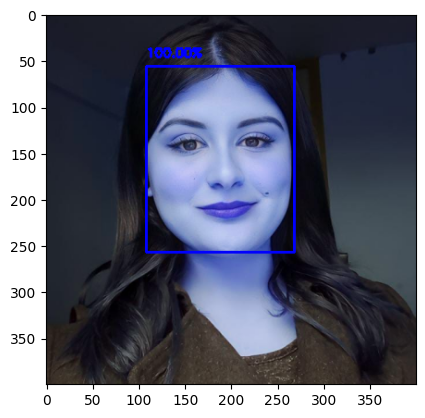

In [56]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## la suite de ce modele est dans le fichier Projet_IA_modele1_v2.ipynb

## Extraire les Caractéristiques avec NASNet-Large

In [ ]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Fonction pour extraire les caractéristiques par batches
def extract_features(generator, model, batch_size):
    features = []
    labels = []
    for inputs_batch, labels_batch in generator:
        inputs_batch_rgb = np.concatenate([inputs_batch] * 3, axis=-1)
        features_batch = model.predict(inputs_batch_rgb)
        features.append(features_batch)
        labels.append(labels_batch)
        if len(features) * batch_size >= generator.samples:
            break
    return np.vstack(features), np.vstack(labels)

In [ ]:
# Extraire les caractéristiques
train_features, y_train = extract_features(train_generator, base_model, batch_size)
test_features, y_test = extract_features(test_generator, base_model, batch_size)

In [ ]:
# Redimensionner les caractéristiques pour les couches fully connected
train_features = train_features.reshape(train_features.shape[0], -1, train_features.shape[-1])
test_features = test_features.reshape(test_features.shape[0], -1, test_features.shape[-1])

In [ ]:
def create_model(**kwargs):
    learning_rate = kwargs.get('learning_rate', 0.001)
    gru_units = kwargs.get('gru_units', 64)
    dropout_rate = kwargs.get('dropout_rate', 0.5)

    model = Sequential()
    model.add(Input(shape=(train_features.shape[1], train_features.shape[2])))
    model.add(GRU(gru_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(class_names), activation='softmax'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Définir la fonction KerasClassifier avec les paramètres
model = KerasClassifier(model=create_model, epochs=20, batch_size=batch_size, verbose=0)

# Définir la grille de paramètres pour Random Search
param_dist = {
    'model__learning_rate': [1e-4, 1e-3, 1e-2],
    'model__gru_units': [32, 64, 128, 256],
    'model__dropout_rate': [0.2, 0.5, 0.7]
}


In [ ]:
# Appliquer Random Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=1)
random_search_result = random_search.fit(train_features, y_train)

In [ ]:
# Meilleurs hyperparamètres trouvés
best_params_random = random_search_result.best_params_

In [ ]:
print("Meilleurs paramètres trouvés par Random Search : ", best_params_random)

## 5. Entraîner le Modèle avec les Hyperparamètres Optimisés

In [ ]:
# Construire et entraîner le modèle avec les meilleurs hyperparamètres trouvés par Random Search
best_learning_rate = best_params_random['model__learning_rate']
best_gru_units = best_params_random['model__gru_units']
best_dropout_rate = best_params_random['model__dropout_rate']

In [ ]:
model = create_model(learning_rate=best_learning_rate, gru_units=best_gru_units, dropout_rate=best_dropout_rate)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = model.fit(train_features, y_train, epochs=20, batch_size=batch_size, validation_data=(test_features, y_test), callbacks=[early_stopping], verbose=1)

In [ ]:
# Sauvegarder le modèle entraîné
model.save('optimized_gru_model_random_search.h5')

## 6. Afficher les Courbes de Performance

In [ ]:
# Afficher les courbes de performance
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')

plt.show()


## 7. Calculer et Afficher les Métriques de Performance

In [ ]:
# Prédictions sur l'ensemble de test
y_pred = model.predict(test_features)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [ ]:
# Calcul des métriques pour chaque classe
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average=None)
recall = recall_score(y_true_classes, y_pred_classes, average=None)
f1 = f1_score(y_true_classes, y_pred_classes, average=None)
g_measure = np.sqrt(precision * recall)

In [ ]:
# Moyenne des métriques
avg_accuracy = accuracy_score(y_true_classes, y_pred_classes)
avg_precision = precision_score(y_true_classes, y_pred_classes, average='macro')
avg_recall = recall_score(y_true_classes, y_pred_classes, average='macro')
avg_f1 = f1_score(y_true_classes, y_pred_classes, average='macro')
avg_g_measure = np.mean(g_measure)

In [ ]:
# Création d'un DataFrame pour les métriques
metrics_df = pd.DataFrame({
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F-Score': f1,
    'G-Measure': g_measure
}, index=class_names)

In [ ]:
metrics_df.loc['Average'] = [avg_accuracy, avg_precision, avg_recall, avg_f1, avg_g_measure]
print(metrics_df)

## 8. Création des Visualisations des Métriques

In [ ]:
# Moyennes des métriques pour chaque phase
avg_values = {
    'Entire Dataset': metrics_df.loc['Average'],
    'Training Phase (70%)': metrics_df.loc['Average'],
    'Testing Phase (30%)': metrics_df.loc['Average']    
}

In [ ]:
# Création du graphique
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(metrics_df.columns))
opacity = 0.8

In [ ]:
rects1 = plt.bar(index, avg_values['Entire Dataset'], bar_width, alpha=opacity, color='b', label='Entire Dataset')
rects2 = plt.bar(index + bar_width, avg_values['Training Phase (70%)'], bar_width, alpha=opacity, color='g', label='Training Phase (70%)')
rects3 = plt.bar(index + 2 * bar_width, avg_values['Testing Phase (30%)'], bar_width, alpha=opacity, color='r', label='Testing Phase (30%)')

In [ ]:
plt.xlabel('Metrics')
plt.ylabel('Avg. Values (%)')
plt.title('Dataset')
plt.xticks(index + bar_width, metrics_df.columns)
plt.legend()

plt.tight_layout()
plt.show()